In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df= pd.read_csv('data iris.csv', delimiter=';')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [66]:
# Buat kamus untuk memetakan kategori ke angka
class_mapping = {label: idx for idx, label in enumerate(df['class'].unique())}

# Terapkan pemetaan ke kolom 'class'
df['class'] = df['class'].map(class_mapping)

EDA

In [69]:
X = df.drop('class', axis=1).values
y = df['class'].values.reshape(-1,1)

In [70]:
# from sklearn.datasets import load_iris
# # Load data
# iris = load_iris()
# X, y = iris.data, iris.target.reshape(-1,1)

In [71]:
def scale(X):
    """
    Standardizes the data in the array X.

    Parameters:
        X (numpy.ndarray): Features array of shape (n_samples, n_features).

    Returns:
        numpy.ndarray: The standardized features array.
    """
    # Calculate the mean and standard deviation of each feature
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)

    # Standardize the data
    X = (X - mean) / std

    return X


In [72]:
X = scale(X)

Model Implementation

In [73]:
class Node():
    """
    A class representing a node in a decision tree.
    """

    def __init__(self, feature=None, threshold=None, left=None, right=None, gain=None, value=None):
        """
        Initializes a new instance of the Node class.

        Args:
            feature: The feature used for splitting at this node. Defaults to None.
            threshold: The threshold used for splitting at this node. Defaults to None.
            left: The left child node. Defaults to None.
            right: The right child node. Defaults to None.
            gain: The gain of the split. Defaults to None.
            value: If this node is a leaf node, this attribute represents the predicted value
                for the target variable. Defaults to None.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain
        self.value = value


In [74]:
class DecisionTree():
    """
    A decision tree classifier for binary classification problems.
    """

    def __init__(self, min_samples=2, max_depth=2):
        """
        Constructor for DecisionTree class.

        Parameters:
            min_samples (int): Minimum number of samples required to split an internal node.
            max_depth (int): Maximum depth of the decision tree.
        """
        self.min_samples = min_samples
        self.max_depth = max_depth

    def split_data(self, dataset, feature, threshold):
        """
        Splits the given dataset into two datasets based on the given feature and threshold.

        Parameters:
            dataset (ndarray): Input dataset.
            feature (int): Index of the feature to be split on.
            threshold (float): Threshold value to split the feature on.

        Returns:
            left_dataset (ndarray): Subset of the dataset with values less than or equal to the threshold.
            right_dataset (ndarray): Subset of the dataset with values greater than the threshold.
        """
        # Create empty arrays to store the left and right datasets
        left_dataset = []
        right_dataset = []
        
        # Loop over each row in the dataset and split based on the given feature and threshold
        for row in dataset:
            if row[feature] <= threshold:
                left_dataset.append(row)
            else:
                right_dataset.append(row)

        # Convert the left and right datasets to numpy arrays and return
        left_dataset = np.array(left_dataset)
        right_dataset = np.array(right_dataset)
        return left_dataset, right_dataset

    def entropy(self, y):
        """
        Computes the entropy of the given label values.

        Parameters:
            y (ndarray): Input label values.

        Returns:
            entropy (float): Entropy of the given label values.
        """
        entropy = 0

        # Find the unique label values in y and loop over each value
        labels = np.unique(y)
        for label in labels:
            # Find the examples in y that have the current label
            label_examples = y[y == label]
            # Calculate the ratio of the current label in y
            pl = len(label_examples) / len(y)
            # Calculate the entropy using the current label and ratio
            entropy += -pl * np.log2(pl)

        # Return the final entropy value
        return entropy

    def information_gain(self, parent, left, right):
        """
        Computes the information gain from splitting the parent dataset into two datasets.

        Parameters:
            parent (ndarray): Input parent dataset.
            left (ndarray): Subset of the parent dataset after split on a feature.
            right (ndarray): Subset of the parent dataset after split on a feature.

        Returns:
            information_gain (float): Information gain of the split.
        """
        # set initial information gain to 0
        information_gain = 0
        # compute entropy for parent
        parent_entropy = self.entropy(parent)
        # calculate weight for left and right nodes
        weight_left = len(left) / len(parent)
        weight_right= len(right) / len(parent)
        # compute entropy for left and right nodes
        entropy_left, entropy_right = self.entropy(left), self.entropy(right)
        # calculate weighted entropy 
        weighted_entropy = weight_left * entropy_left + weight_right * entropy_right
        # calculate information gain 
        information_gain = parent_entropy - weighted_entropy
        return information_gain

    
    def best_split(self, dataset, num_samples, num_features):
        """
        Finds the best split for the given dataset.

        Args:
        dataset (ndarray): The dataset to split.
        num_samples (int): The number of samples in the dataset.
        num_features (int): The number of features in the dataset.

        Returns:
        dict: A dictionary with the best split feature index, threshold, gain, 
              left and right datasets.
        """
        # dictionary to store the best split values
        best_split = {'gain':- 1, 'feature': None, 'threshold': None}
        # loop over all the features
        for feature_index in range(num_features):
            #get the feature at the current feature_index
            feature_values = dataset[:, feature_index]
            #get unique values of that feature
            thresholds = np.unique(feature_values)
            # loop over all values of the feature
            for threshold in thresholds:
                # get left and right datasets
                left_dataset, right_dataset = self.split_data(dataset, feature_index, threshold)
                # check if either datasets is empty
                if len(left_dataset) and len(right_dataset):
                    # get y values of the parent and left, right nodes
                    y, left_y, right_y = dataset[:, -1], left_dataset[:, -1], right_dataset[:, -1]
                    # compute information gain based on the y values
                    information_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if conditions are met
                    if information_gain > best_split["gain"]:
                        best_split["feature"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["left_dataset"] = left_dataset
                        best_split["right_dataset"] = right_dataset
                        best_split["gain"] = information_gain
        return best_split

    
    def calculate_leaf_value(self, y):
        """
        Calculates the most occurring value in the given list of y values.

        Args:
            y (list): The list of y values.

        Returns:
            The most occurring value in the list.
        """
        y = list(y)
        #get the highest present class in the array
        most_occuring_value = max(y, key=y.count)
        return most_occuring_value
    
    def build_tree(self, dataset, current_depth=0):
        """
        Recursively builds a decision tree from the given dataset.

        Args:
        dataset (ndarray): The dataset to build the tree from.
        current_depth (int): The current depth of the tree.

        Returns:
        Node: The root node of the built decision tree.
        """
        # split the dataset into X, y values
        X, y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape
        # keeps spliting until stopping conditions are met
        if n_samples >= self.min_samples and current_depth <= self.max_depth:
            # Get the best split
            best_split = self.best_split(dataset, n_samples, n_features)
            # Check if gain isn't zero
            if best_split["gain"]:
                # continue splitting the left and the right child. Increment current depth
                left_node = self.build_tree(best_split["left_dataset"], current_depth + 1)
                right_node = self.build_tree(best_split["right_dataset"], current_depth + 1)
                # return decision node
                return Node(best_split["feature"], best_split["threshold"],
                            left_node, right_node, best_split["gain"])

        # compute leaf node value
        leaf_value = self.calculate_leaf_value(y)
        # return leaf node value
        return Node(value=leaf_value)
    
    def fit(self, X, y):
        """
        Builds and fits the decision tree to the given X and y values.

        Args:
        X (ndarray): The feature matrix.
        y (ndarray): The target values.
        """
        dataset = np.concatenate((X, y), axis=1)  
        self.root = self.build_tree(dataset)

    def predict(self, X):
        """
        Predicts the class labels for each instance in the feature matrix X.

        Args:
        X (ndarray): The feature matrix to make predictions for.

        Returns:
        list: A list of predicted class labels.
        """
        # Create an empty list to store the predictions
        predictions = []
        # For each instance in X, make a prediction by traversing the tree
        for x in X:
            prediction = self.make_prediction(x, self.root)
            # Append the prediction to the list of predictions
            predictions.append(prediction)
        # Convert the list to a numpy array and return it
        np.array(predictions)
        return predictions
    
    def make_prediction(self, x, node):
        """
        Traverses the decision tree to predict the target value for the given feature vector.

        Args:
        x (ndarray): The feature vector to predict the target value for.
        node (Node): The current node being evaluated.

        Returns:
        The predicted target value for the given feature vector.
        """
        # if the node has value i.e it's a leaf node extract it's value
        if node.value != None: 
            return node.value
        else:
            #if it's node a leaf node we'll get it's feature and traverse through the tree accordingly
            feature = x[node.feature]
            if feature <= node.threshold:
                return self.make_prediction(x, node.left)
            else:
                return self.make_prediction(x, node.right)



Evaluation

In [75]:
def train_test_split(X, y, random_state=41, test_size=0.2):
    """
    Splits the data into training and testing sets.

    Parameters:
        X (numpy.ndarray): Features array of shape (n_samples, n_features).
        y (numpy.ndarray): Target array of shape (n_samples,).
        random_state (int): Seed for the random number generator. Default is 42.
        test_size (float): Proportion of samples to include in the test set. Default is 0.2.

    Returns:
        Tuple[numpy.ndarray]: A tuple containing X_train, X_test, y_train, y_test.
    """
    # Get number of samples
    n_samples = X.shape[0]

    # Set the seed for the random number generator
    np.random.seed(random_state)

    # Shuffle the indices
    shuffled_indices = np.random.permutation(np.arange(n_samples))

    # Determine the size of the test set
    test_size = int(n_samples * test_size)

    # Split the indices into test and train
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]

    # Split the features and target arrays into test and train
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, X_test, y_train, y_test


In [76]:
def accuracy(y_true, y_pred):
    """
    Computes the accuracy of a classification model.

    Parameters:
    ----------
        y_true (numpy array): A numpy array of true labels for each data point.
        y_pred (numpy array): A numpy array of predicted labels for each data point.

    Returns:
    ----------
        float: The accuracy of the model
    """
    y_true = y_true.flatten()
    total_samples = len(y_true)
    correct_predictions = np.sum(y_true == y_pred)
    return (correct_predictions / total_samples) 


In [77]:
def balanced_accuracy(y_true, y_pred):
    """Calculate the balanced accuracy for a multi-class classification problem.

    Parameters
    ----------
        y_true (numpy array): A numpy array of true labels for each data point.
        y_pred (numpy array): A numpy array of predicted labels for each data point.

    Returns
    -------
        balanced_acc : The balanced accuracyof the model
        
    """
    y_pred = np.array(y_pred)
    y_true = y_true.flatten()
    # Get the number of classes
    n_classes = len(np.unique(y_true))

    # Initialize an array to store the sensitivity and specificity for each class
    sen = []
    spec = []
    # Loop over each class
    for i in range(n_classes):
        # Create a mask for the true and predicted values for class i
        mask_true = y_true == i
        mask_pred = y_pred == i

        # Calculate the true positive, true negative, false positive, and false negative values
        TP = np.sum(mask_true & mask_pred)
        TN = np.sum((mask_true != True) & (mask_pred != True))
        FP = np.sum((mask_true != True) & mask_pred)
        FN = np.sum(mask_true & (mask_pred != True))

        # Calculate the sensitivity (true positive rate) and specificity (true negative rate)
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)

        # Store the sensitivity and specificity for class i
        sen.append(sensitivity)
        spec.append(specificity)
    # Calculate the balanced accuracy as the average of the sensitivity and specificity for each class
    average_sen =  np.mean(sen)
    average_spec =  np.mean(spec)
    balanced_acc = (average_sen + average_spec) / n_classes

    return balanced_acc


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41, test_size=0.2)

In [79]:
#create model instance
model = DecisionTree(2, 2)

# Fit the decision tree model to the training data.
model.fit(X_train, y_train)

# Use the trained model to make predictions on the test data.
predictions = model.predict(X_test)

# Calculate evaluating metrics
print(f"Model's Accuracy: {accuracy(y_test, predictions)}")
print(f"Model's Balanced Accuracy: {balanced_accuracy(y_test, predictions)}")


Model's Accuracy: 0.9
Model's Balanced Accuracy: 0.6196969696969697


Sklearn Implementation

In [80]:
from sklearn.tree import DecisionTreeClassifier
# Create a decision tree classifier model object.
decision_tree_classifier = DecisionTreeClassifier()

# Train the decision tree classifier model using the training data.
decision_tree_classifier.fit(X_train, y_train)

# Use the trained model to make predictions on the test data.
predictions_sklearn = decision_tree_classifier.predict(X_test)

# Calculate evaluating metrics
print(f" Model's Accuracy: {accuracy(y_test, predictions_sklearn)}")
print(f"Model's Balanced Accuracy: {balanced_accuracy(y_test, predictions_sklearn)}")


 Model's Accuracy: 0.8333333333333334
Model's Balanced Accuracy: 0.585778841041999


In [81]:
import numpy as np

def confusion_matrix(y_true, y_pred):
    """
    Membuat Confusion Matrix secara manual.
    
    Parameters:
    y_true : list atau array (label sebenarnya)
    y_pred : list atau array (label yang diprediksi)
    
    Returns:
    matrix : dict dengan nilai TP, TN, FP, FN
    """
    # Inisialisasi nilai awal
    TP = TN = FP = FN = 0
    
    # Looping untuk menghitung TP, TN, FP, FN
    for yt, yp in zip(y_true, y_pred):
        if yt == 1 and yp == 1:
            TP += 1
        elif yt == 0 and yp == 0:
            TN += 1
        elif yt == 0 and yp == 1:
            FP += 1
        elif yt == 1 and yp == 0:
            FN += 1
            
    # Membuat dictionary confusion matrix
    matrix = {
        "True Positive (TP)": TP,
        "False Negative (FN)": FN,
        "False Positive (FP)": FP,
        "True Negative (TN)": TN
    }
    
    return matrix

# Contoh data label asli dan prediksi model
# y_true = [1, 0, 1, 1, 0, 1, 0, 0, 1, 0]
# y_pred = [1, 0, 1, 0, 0, 1, 1, 0, 1, 0]

# Panggil fungsi
conf_matrix = confusion_matrix(y_test, predictions)
print(conf_matrix)


{'True Positive (TP)': 8, 'False Negative (FN)': 0, 'False Positive (FP)': 0, 'True Negative (TN)': 9}


Confusion Matrix:
[[ 9  0  0]
 [ 0  8  3]
 [ 0  0 10]]


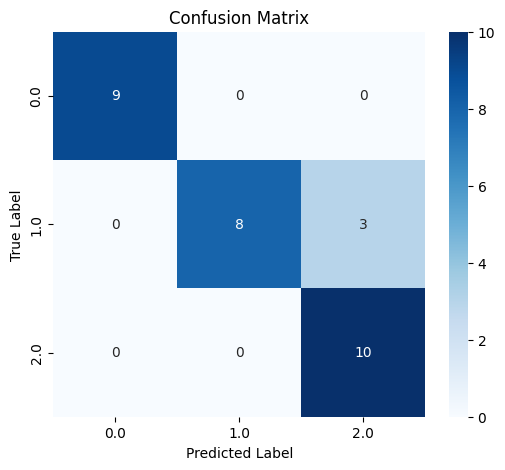

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def confusion_matrix(y_true, y_pred, labels=None):
    """
    Membuat confusion matrix dari label sebenarnya dan prediksi.
    :param y_true: List atau array label sebenarnya
    :param y_pred: List atau array label prediksi
    :param labels: List dari semua label unik (opsional)
    :return: Confusion matrix sebagai numpy array
    """
    if labels is None:
        labels = np.unique(np.concatenate((y_true, y_pred)))
    
    matrix = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: idx for idx, label in enumerate(labels)}
    
    for true, pred in zip(y_true, y_pred):
        matrix[label_to_index[true], label_to_index[pred]] += 1
    
    return matrix, labels

def plot_confusion_matrix(cm, labels):
    """
    Memvisualisasikan confusion matrix.
    :param cm: Confusion matrix dalam bentuk numpy array
    :param labels: Label kelas
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Contoh penggunaan
# y_true = ["cat", "dog", "dog", "cat", "cat", "dog", "cat", "bird", "bird", "bird"]
# y_pred = ["dog", "dog", "dog", "cat", "bird", "dog", "cat", "bird", "cat", "bird"]

y_test1 = np.ravel(y_test)  # Mengubah ke array 1D jika masih dalam bentuk (n,1)
predictions1 = np.ravel(predictions)


cm, labels = confusion_matrix(y_test1, predictions1)
print("Confusion Matrix:")
print(cm)
plot_confusion_matrix(cm, labels)